# A notebook with a simple Solow model 
You ca run each cell by pressing the run tool or shift+enter

# Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import  ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pylab  as plt 
import seaborn as sns
import qgrid

import sys
sys.path.append('modelflow/')

from modelsandbox import newmodel     
from modelmanipulation import explode  

# Specify the model 
The explode function will rewrite the business logic.

In [2]:
fsolow = explode('''\
Y         = a * k**alfa * l **(1-alfa) 
C         = (1-SAVING_RATIO)  * Y 
I         = Y - C 
diff(K)   = I-depreciates_rate * K(-1)
diff(l)   = labor_growth * L(-1) 
K_intense = K/L 
''')
print(fsolow)

FRML <> Y         = A * K**ALFA * L **(1-ALFA)  $
FRML <> C         = (1-SAVING_RATIO)  * Y  $
FRML <> I         = Y - C  $
FRML <> K=K(-1)+(I-DEPRECIATES_RATE * K(-1))$
FRML <> L=L(-1)+(LABOR_GROWTH * L(-1))$
FRML <> K_INTENSE = K/L  $


# Create a model class instance

In [3]:
msolow = newmodel(fsolow)

This model has simultaneous elements or cyclical elements. The formulars will be evaluated in input sequence


# Show model structure

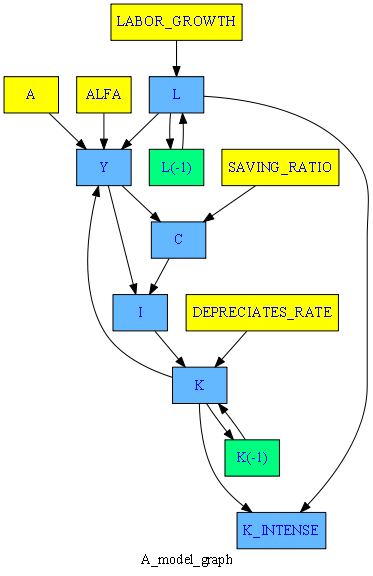

In [4]:
msolow.drawmodel(sink = 'K_INTENSE')

# Show solving structure (only current year)

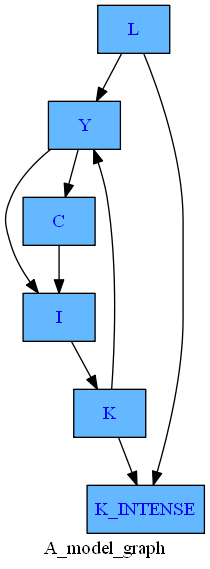

In [5]:
msolow.drawendo(sink = 'K_INTENSE',source='L')

# Create DataFrame with baseline exogenous 

In [6]:
N = 300
df = pd.DataFrame({'L':[100]*N,'K':[100]*N})
df.loc[:,'ALFA'] = 0.5
df.loc[:,'A'] = 1.
df.loc[:,'DEPRECIATES_RATE'] = 0.05
df.loc[:,'LABOR_GROWTH'] = 0.01
df.loc[:,'SAVING_RATIO'] = 0.05
display(df.head())

,L,K,ALFA,A,DEPRECIATES_RATE,LABOR_GROWTH,SAVING_RATIO
0,100,100,0.5,1.0,0.05,0.01,0.05
1,100,100,0.5,1.0,0.05,0.01,0.05
2,100,100,0.5,1.0,0.05,0.01,0.05
3,100,100,0.5,1.0,0.05,0.01,0.05
4,100,100,0.5,1.0,0.05,0.01,0.05


# Run Baseline

In [7]:
res1 = msolow(df,antal=100,first_test=10,silent=1)
display(res1.head())

,L,K,ALFA,A,DEPRECIATES_RATE,LABOR_GROWTH,SAVING_RATIO,Y,K_INTENSE,C,I
0,100.000000,100.000000,0.5,1.0,0.05,0.01,0.05,0.000000,0.000000,0.000000,0.000000
1,101.000000,100.025580,0.5,1.0,0.05,0.01,0.05,100.511609,0.990352,95.486029,5.025580
2,102.010000,100.076226,0.5,1.0,0.05,0.01,0.05,101.038487,0.981043,95.986562,5.051924
3,103.030100,100.151443,0.5,1.0,0.05,0.01,0.05,101.580575,0.972060,96.501546,5.079029
4,104.060401,100.250762,0.5,1.0,0.05,0.01,0.05,102.137821,0.963390,97.030930,5.106891


# Create interactive widgets 
If you are not familiar with Python and Ipywidgets, don't try to understand the code. 
Just notice that it is fairly short. 

In [22]:
# Define output widget
def vis_alt3(dfs,model,title='Show variables'):
    ''' display tabbed widget with results from different dataframes, usuallly 2 but more can be shown'''
    avar = dfs[0].columns
    outlist =     [widgets.Output() for var in avar]
    deplist =     [widgets.Output() for var in avar]
    reslist =     [widgets.Output() for var in avar]
    attlist =     [widgets.Output() for var in avar]
    varouttablist =  [widgets.Tab(children = [out,att,dep,res]) for out,att,dep,res  in zip(outlist,attlist,deplist,reslist)]
    for var,varouttab in zip(avar,varouttablist):
        for i,tabtext in enumerate(['Graph','Attribution','Dependencies','Results']):
            varouttab.set_title(i,tabtext)

    controllist = [widgets.VBox([varouttab]) for varouttab in varouttablist]
    tab = widgets.Tab(children = controllist)
    for i,(var,out) in enumerate(zip(avar,controllist)):
        tab.set_title(i, var) 
    
    def test1(b):
        sel = b['new']
        out = outlist[sel]
        dep = deplist[sel]
        res = reslist[sel]
        att = attlist[sel]
        var = avar[sel]
        with out:
            clear_output()
            fig,ax = plt.subplots(figsize=(10,6))
            ax.set_title(var,fontsize=14)
            for i,df in enumerate(dfs):
                data = df.loc[:,var]
                data.plot(ax=ax,legend=False,fontsize=14)
                x_pos = data.index[-1]
                if i == 0:
                    basevalue = data.values[-1]
                    ax.text(x_pos, data.values[-1],' Baseline',fontsize=14)
                else:
                    alt=i if len(dfs) >= 3 else ''
                    if abs(data.values[-1]/basevalue-1) > 0.01:
                        ax.text(x_pos, data.values[-1]  ,f' Alternative{alt}',fontsize=14)
                    else:
                        ax.text(x_pos, data.values[-1]  ,f'                and Alternative{alt}',fontsize=14)
            plt.show(fig)
        with dep:
            clear_output()
            model.draw(var,up=2,down=2,svg=1)
        with res:
            clear_output()
            print(model.get_values(var).T)
        with att:
            clear_output()
            old = model.current_per
            model.smpl(N-20,N)
            print('What explains the difference between the baseline and the alternative run (last 20 years)')
            print(model.allvar[var]['frml'])
            model.explain(var,up=0,dec=1,size=(9,12),svg=1,HR=0)
            model.current_per = old
            
    display(tab) 

    test1({'new':0})
    tab.observe(test1,'selected_index')
    return tab

# Define tata extraction
def get_alt(mmodel,pat):
    ''' Retrieves variables matching pat from a model '''
    varnames = mmodel.vlist(pat)
    per = mmodel.current_per
    return [mmodel.basedf.loc[per,varnames],mmodel.lastdf.loc[per,varnames]]
,

# Define the imput widget 
def inputwidget(model,df,wdef={'ALFA':0.5,'DEPRECIATES_RATE':0.05, 'LABOR_GROWTH':0.01, 'SAVING_RATIO':0.05},start_upd = 3):
    wexp  = [widgets.Label(value="Input new parameter. They will take effect time = 3")]
    wset  = [widgets.FloatSlider(description=var,min=-0.,max=1.,value=value,step=0.01,
                                layout={'width':'50%'},style={'description_width':'30%'}) for var,value in wdef.items()]
    wgo   = widgets.Button(description="Run")
    wreset   = widgets.Button(description="Reset to default")
    wbut  = widgets.HBox([wgo,wreset])
    w     = widgets.VBox(wexp+wset+[wbut])

    # This function is run when the button is clecked 
    def run(b):
        mulstart       = df.copy()
        for i,var in enumerate(wdef.keys()):
            mulstart.loc[start_upd:,var] =   wset[i].value
       # with out:
        clear_output()
        mul = model(mulstart,conv=['Y','K'],antal=100,alfa=0.5,ljit=0,relconv = 0.000000001,silent=True,ldump=0)
        clear_output()
        display(w)
        a = vis_alt3(get_alt(model,['Y','C','I','K','L','K_INTENSE']),model)

    def reset(b):
        for i,var in enumerate(wdef.keys()):
            wset[i].value  =   wdef[var]


    # Assign the function to the button  
    wgo.on_click(run)
    wreset.on_click(reset)
    out = widgets.Output()
    
    return w

# Run interactive widget 

In [23]:
display(inputwidget(msolow,df))      

In [15]:
msolow.get_att_pct('Y',start=3,end=10).T

,ALFA,K,A,L
3,97.464299,2.685559,6.141592e-07,6.141592e-07
4,95.660038,4.595210,6.313811e-07,6.313811e-07
5,94.159467,6.182409,6.504892e-07,6.504892e-07
6,92.823377,7.594762,6.706603e-07,6.706603e-07
7,91.592554,8.895077,6.915132e-07,6.915132e-07
8,90.437279,10.114899,7.128534e-07,7.128534e-07
9,89.340802,11.272019,7.345783e-07,7.345783e-07
10,88.292818,12.377398,7.566178e-07,7.566178e-07
